In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import utils.visualization_tb as vi

import warnings

warnings.filterwarnings("ignore")
sns.set_theme()

In [2]:
df = pd.read_csv("data/train.csv", index_col = 0)
df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [3]:
df.shape

(1460, 80)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
# Let's start by dropping some columns that have too many NaNs
to_drop = ["Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
df = df.drop(to_drop, axis = 1)

In [6]:
# Now let's split the numerical and categorical variables for later
categorical_variables = []
numerical_variables = []

for column in df.columns:
    if df[column].dtype == "object":
        categorical_variables.append(column)
    else:
        numerical_variables.append(column)

## Categorical variables
Now, let's continue with the categorical variables by splitting them further into ordinal (encoding) and nominal (dummies).

In [7]:
ordinal_variables = ["LotShape", "LandContour", "LandSlope", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "GarageFinish", "GarageQual", "GarageCond"]
nominal_variables = [var for var in categorical_variables if var not in ordinal_variables]

## Filling NaNs

With everything in place, I'll fill in the NaN values for both, numerical variables (using the mean) and categorical variables (using the mode).

However, to be completely thorough, I should check numerical variables to see in the distributions are biased, in which case the median would be a more robust metric.

As my purpose is to compare Linear, Lasso and Ridge regression I won't focus that much on the processing side of this and I will just stick to the mean.

In [8]:
### NUMERICAL VARIABLES
# Calculate the means for all the numerical variables
numerical_variables_means = list(df[numerical_variables].mean().values)
# Zip it together with the variable names in a dict
numerical_variables_replacement = dict(zip(numerical_variables, numerical_variables_means))

# Replace values using the dict
df[numerical_variables] = df[numerical_variables].fillna(value = numerical_variables_replacement)

In [9]:
### CATEGORICAL VARIABLES
#Find the modes for all the numerical variables
categorical_variables_modes = list(df[categorical_variables].mode().values[0])
# Zip it together with the variable names in a dict
categorical_variables_replacement = dict(zip(categorical_variables, categorical_variables_modes))

# Replace values using the dict
df[categorical_variables] = df[categorical_variables].fillna(value = categorical_variables_replacement)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

Now that the dataset is cleaned, I'll continue by processing the categorical variables further: either by encoding or using dummies.

## Categorical variables transformation

In [11]:
# Let's start with the nominal variables as it is jsut getting the dummies
df = pd.get_dummies(df, prefix = nominal_variables, columns = nominal_variables)

In [12]:
df.shape

(1460, 214)

In [13]:
# For the encoding, I usually prefer to do it manually, as OneHotEncoder does it alphabetically, which isn't always the correct order
# However, I won't look for the correct numerical scale (in case there is any) for this example
# In some cases, one category is not just "better" but for instance, "twice as better" or the values do follow an established rule
LotShape_map = {
    "Reg" : 4,
    "IR1" : 3,
    "IR2" : 2,
    "IR3" : 1
}

LandContour_map = {
    "Lvl" : 4,
    "Bnk" : 3,
    "HLS" : 2,
    "Low" : 1
}

LandSlope_map = {
    "Gtl" : 3,
    "Mod" : 2,
    "Sev" : 1
}

ExterQual_map = {
    "Ex" : 5,
    "Gd" : 4,
    "TA" : 3,
    "Fa" : 2,
    "Po" : 1
}

ExterCond_map = {
    "Ex" : 5,
    "Gd" : 4,
    "TA" : 3,
    "Fa" : 2,
    "Po" : 1
}

BsmtQual_map = {
    "Ex" : 6,
    "Gd" : 5,
    "TA" : 4,
    "Fa" : 3,
    "Po" : 2,
    "NA" : 1
}

BsmtCond_map = {
    "Ex" : 6,
    "Gd" : 5,
    "TA" : 4,
    "Fa" : 3,
    "Po" : 2,
    "NA" : 1
}

BsmtExposure_map = {
    "Gd" : 5,
    "Av" : 4,
    "Mn" : 3,
    "No" : 2,
    "NA" : 1
}

BsmtFinType1_map = {
    "GLQ" : 7,
    "ALQ" : 6,
    "BLQ" : 5,
    "Rec" : 4,
    "LwQ" : 3,
    "Unf" : 2,
    "NA" : 1
}

BsmtFinType2_map = {
    "GLQ" : 7,
    "ALQ" : 6,
    "BLQ" : 5,
    "Rec" : 4,
    "LwQ" : 3,
    "Unf" : 2,
    "NA" : 1
}

HeatingQC_map = {
    "Ex" : 5,
    "Gd" : 4,
    "TA" : 3,
    "Fa" : 2,
    "Po" : 1
}

KitchenQual_map = {
    "Ex" : 5,
    "Gd" : 4,
    "TA" : 3,
    "Fa" : 2,
    "Po" : 1
}

Functional_map = {
    "Typ" : 8,
    "Min1" : 7,
    "Min2" : 6,
    "Mod" : 5,
    "Maj1" : 4,
    "Maj2" : 3,
    "Sev" : 2,
    "Sal" : 1
}

GarageFinish_map = {
    "Fin" : 4,
    "RFn" : 3,	
    "Unf" : 2,
    "NA" : 1
}

GarageFinish_map = {
    "Fin" : 4,
    "RFn" : 3,	
    "Unf" : 2,
    "NA" : 1
}

GarageQual_map = {
    "Ex" : 6,
    "Gd" : 5,
    "TA" : 4,
    "Fa" : 3,
    "Po" : 2,
    "NA" : 1
}

GarageCond_map = {
    "Ex" : 6,
    "Gd" : 5,
    "TA" : 4,
    "Fa" : 3,
    "Po" : 2,
    "NA" : 1
}

df["LotShape"] = df["LotShape"].map(LotShape_map)
df["LandContour"] = df["LandContour"].map(LandContour_map)
df["LandSlope"] = df["LandSlope"].map(LandSlope_map)
df["ExterQual"] = df["ExterQual"].map(ExterQual_map)
df["ExterCond"] = df["ExterCond"].map(ExterCond_map)
df["BsmtQual"] = df["BsmtQual"].map(BsmtQual_map)
df["BsmtCond"] = df["BsmtCond"].map(BsmtCond_map)
df["BsmtExposure"] = df["BsmtExposure"].map(BsmtExposure_map)
df["BsmtFinType1"] = df["BsmtFinType1"].map(BsmtFinType1_map)
df["BsmtFinType2"] = df["BsmtFinType2"].map(BsmtFinType2_map)
df["HeatingQC"] = df["HeatingQC"].map(HeatingQC_map)
df["KitchenQual"] = df["KitchenQual"].map(KitchenQual_map)
df["Functional"] = df["Functional"].map(Functional_map)
df["GarageFinish"] = df["GarageFinish"].map(GarageFinish_map)
df["GarageQual"] = df["GarageQual"].map(GarageQual_map)
df["GarageCond"] = df["GarageCond"].map(GarageCond_map)

## Correlation matrix

While doing the mapping I realized that some of the variables are too similar, for instance: GarageQual and GarageCond are probably going to have high correlation.

For this reason, it'll be interesting comparing the results of a LinearRegression Model with Ridge/Lasso, as the regularization will bring the coefficients of some variables close to zero.

I'll get the correlations first to have an idea of what variables are relevant when calculating the SalePrice (my target variable).

In [30]:
corr = df.corr()

# Let's see the top variables with positive correlation with Sale Price
corr["SalePrice"].sort_values(ascending = False).head(20)

SalePrice           1.000000
OverallQual         0.790982
GrLivArea           0.708624
ExterQual           0.682639
KitchenQual         0.659600
BsmtQual            0.650138
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
FullBath            0.560664
GarageFinish        0.537242
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
YearRemodAdd        0.507101
Foundation_PConc    0.497734
MasVnrArea          0.475241
GarageYrBlt         0.470177
Fireplaces          0.466929
HeatingQC           0.427649
Name: SalePrice, dtype: float64

In [25]:
# Let's see the top variables with negative correlation with Sale Price
corr["SalePrice"].sort_values().head(20)

MasVnrType_None        -0.367456
GarageType_Detchd      -0.354141
Foundation_CBlock      -0.343263
MSZoning_RM            -0.288065
LotShape               -0.267759
CentralAir_N           -0.251328
SaleType_WD            -0.242598
RoofStyle_Gable        -0.224744
PavedDrive_N           -0.212630
Foundation_BrkTil      -0.204117
Electrical_FuseA       -0.193978
Neighborhood_OldTown   -0.192189
Neighborhood_NAmes     -0.188513
Neighborhood_Edwards   -0.179949
Exterior1st_MetalSd    -0.167068
Neighborhood_IDOTRR    -0.164056
HouseStyle_1.5Fin      -0.163466
Exterior2nd_MetalSd    -0.162389
Exterior2nd_Wd Sdng    -0.161800
Exterior1st_Wd Sdng    -0.158619
Name: SalePrice, dtype: float64

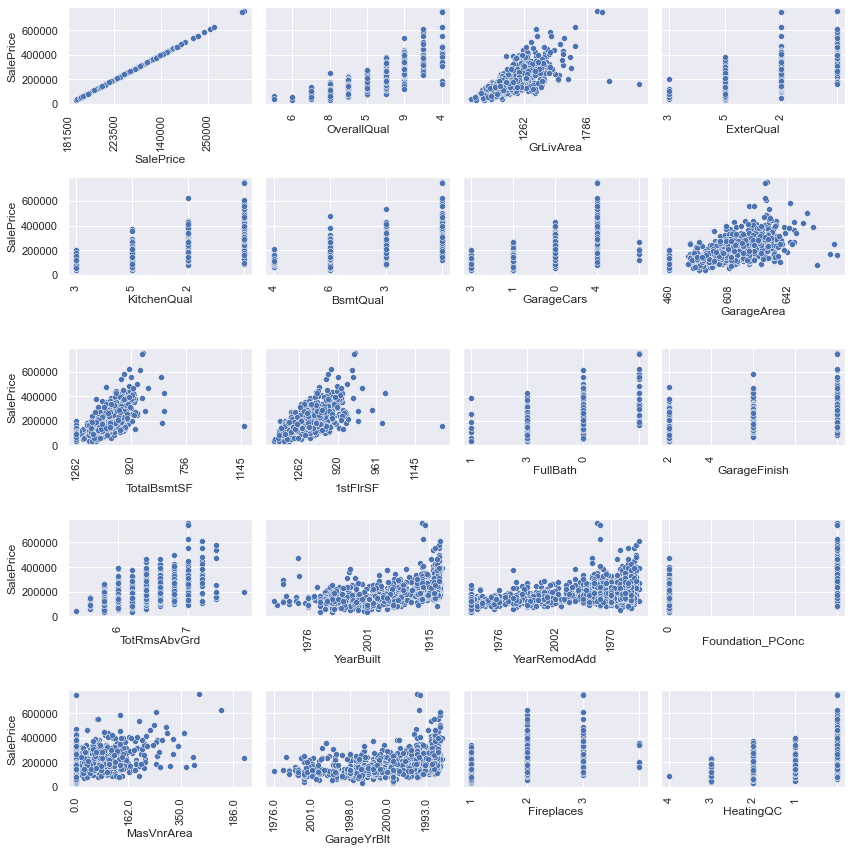

In [26]:
top_positive_corr = corr["SalePrice"].sort_values(ascending = False).head(20).index

plotter = vi.plotter()
fig = plotter.scatter(df[top_positive_corr], "SalePrice", 4)

<AxesSubplot:xlabel='KitchenQual', ylabel='SalePrice'>

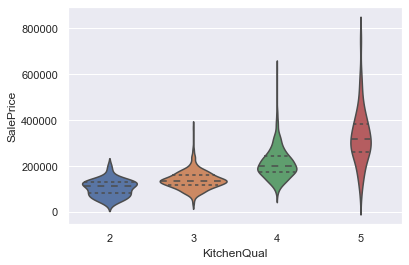

In [28]:
# Some of these are categorical, so I'll plot them differently
to_plot = ["OverallQual", "ExterQual", "KitchenQual", "BmstQual", "GarageCars", "FullBath", "GarageFinish", "TotRmsAbvGrd", "Foundation_PConc", "Fireplaces", "HeatingQC"]

# sns.violinplot(x = "KitchenQual", y = "SalePrice", data = df, inner = "quartile")

<AxesSubplot:>

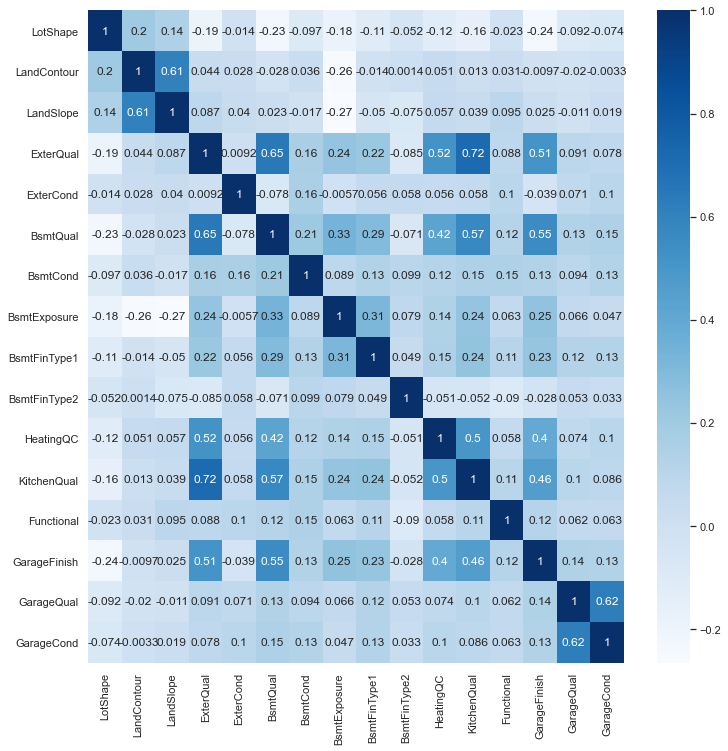

In [18]:
plt.figure(figsize = (12, 12))
sns.heatmap(corr.loc[ordinal_variables, ordinal_variables], annot = True, cmap = "Blues")